# tf-NLP

## (Re) Introduction to Tensorflow Natural Language Processing

### Abstract

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Here Machine Learning can help us segmenting large quantities of incoming messages. But what type Machine Learning is the best suited?

I am running a couple of experiments to show the performace of different solutions and their trade-off - how long does it take to get a prediction from a given algorithm? Is a higher accuracy worth the wait?

![(Re) Introduction to Tensorflow Natural Language Processing](./assets/tf_nlp_desaster_tweets_06.png)

## Dataset

[https://www.kaggle.com/competitions/nlp-getting-started/data](https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip)

```
.
├── data
│   ├── test.csv
│   └── train.csv
```

In [1]:
import datetime
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import tensorflow as tf
# tf-hub bug https://stackoverflow.com/questions/69339917/importerror-cannot-import-name-dnn-logit-fn-builder-from-partially-initialize
from tensorflow_estimator.python.estimator.canned.dnn import dnn_logit_fn_builder
import tensorflow_hub as hub
from tensorflow.keras.layers import (
    TextVectorization,
    Embedding,
    Input,
    Dense,
    GlobalAveragePooling1D,
    GlobalMaxPool1D,
    LSTM,
    GRU,
    Bidirectional,
    Conv1D
)

2023-04-24 12:32:46.054605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from helper_functions import (
    create_tensorboard_callback,
    plot_loss_curves,
    compare_histories,
    calculate_metrics,
    time_to_prediction
)

In [3]:
SEED = 42
LOG_DIR = 'tensorboad'

### Exploration

In [5]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df.head(5)
# target 1 = disaster / 0 = not a disaster

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


|   | id | keyword | location | text | target |
|  -- | -- | -- | -- | -- | -- |
| 0 | 1 | NaN | NaN | Our Deeds are the Reason of this #earthquake M... | 1 |
| 1 | 4 | NaN | NaN | Forest fire near La Ronge Sask. Canada | 1 |
| 2 | 5 | NaN | NaN | All residents asked to 'shelter in place' are ... | 1 |
| 3 | 6 | NaN | NaN | 13,000 people receive #wildfires evacuation or... | 1 |
| 4 | 7 | NaN | NaN | Just got sent this photo from Ruby #Alaska as ... | 1 |

In [6]:
# checking if the dataset is balanced
print(train_df.target.value_counts())
# 0    4342
# 1    3271

print(len(train_df), len(test_df))
# 7613 3263

0    4342
1    3271
Name: target, dtype: int64
7613 3263


In [7]:
train_df_shuffle = train_df.sample(frac=1, random_state=SEED)

train_df_shuffle.head(5)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


|   | id | keyword | location | text | target |
|  -- | -- | -- | -- | -- | -- |
| 2644 | 3796 | destruction | NaN | So you have a new weapon that can cause un-ima... | 1 |
| 2227 | 3185 | deluge | NaN | The f$&amp;@ing things I do for #GISHWHES Just... | 0 |
| 5448 | 7769 | police | UK | DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe... | 1 |
| 132 | 191 | aftershock | NaN | Aftershock back to school kick off was great. ... | 0 |
| 6845 | 9810 | trauma | Montgomery County, MD | in response to trauma Children of Addicts deve... | 0 |

In [8]:
random_index = random.randint(0, len(train_df)-5)

for row in train_df_shuffle[['text', 'target']][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}","(disaster)" if target>0 else "(not a disaster)")
    print(f"Text: {text}\n")
    print("---\n")

Target: 0 (not a disaster)
Text: Do you have a plan? Emergency Preparedness for #Families of
Children with Special Needs  http://t.co/RdOVqaUAx5  #autism #specialneeds

---

Target: 0 (not a disaster)
Text: @dopeitsval ahh you're bomb baby ??

---

Target: 0 (not a disaster)
Text: @SirTitan45  Mega mood swing on a 24 hr schedule. Isn't that how structural failure occurs?

---

Target: 0 (not a disaster)
Text: @FoxNewsInsider All Obama is doing is giving a false time schedule on Iran testing there first bomb      Bomb = Nuclear Suicide Vest

---

Target: 1 (disaster)
Text: SSP East says a car AEG 061 driven by a young man collided with Akram's carhot words were exchanged n he did firing in air1bullet hit tyre

---



```
Target: 1 (disaster)
Text: @WesleyLowery ?????? how are you going to survive this devastation?

---

Target: 0 (not a disaster)
Text: Hollywood movie about trapped miners released in Chile http://t.co/xe0EE1Fzfh

---

Target: 0 (not a disaster)
Text: #sing #tsunami Beginners #computer tutorial.: http://t.co/ukQYbhxMQI Everyone Wants To Learn To Build A Pc. Re http://t.co/iDWS2ZgYsa

---

Target: 1 (disaster)
Text: #Reddit updates #content #policy promises to quarantine Û÷extremely offensiveÛª communities http://t.co/EHGtZhKAn4

---

Target: 1 (disaster)
Text: Japan Marks 70th Anniversary of Hiroshima Atomic Bombing http://t.co/cQLM9jOJOP

---
```

### Train Test Split

In [9]:
train_tweets, val_tweets, train_labels, val_labels = train_test_split(
    train_df_shuffle['text'].to_numpy(),
    train_df_shuffle['target'].to_numpy(),
    test_size=0.1,
    random_state=SEED)

print(len(train_tweets), len(val_tweets))
# 6851 762

6851 762


### Tokenization and Embedding

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to ["vectorize" the text](https://www.tensorflow.org/text/guide/word_embeddings)) before feeding it to the model.


#### Tokenization

[TextVectorization layer](https://www.tensorflow.org/tutorials/keras/text_classification) is a Keras layer to standardize, tokenize, and vectorize the dataset.

In [10]:
# find average number of words in tweets
average_tokens_per_tweet=round(sum([len(i.split()) for i in train_tweets])/len(train_tweets))
print(average_tokens_per_tweet)
# 15

15


In [11]:
# create text vectorizer
max_features = 10000 # limit to most common words
sequence_length = 15 # limit to average number of words in tweets

text_vectorizer = TextVectorization(
    max_tokens=max_features, # set a value to only include most common words
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None, # set value to form common word groups
    output_mode='int',
    output_sequence_length=sequence_length, # set value to limit tweet size
    pad_to_max_tokens=True # fluff tweets that are shorter than set max length
)

In [12]:
# fit text vectorizer to training data
text_vectorizer.adapt(train_tweets)

In [13]:
# test fitted vectorizer
sample_sentence1 = "Next I'm buying Coca-Cola to put the cocaine back in"
sample_sentence2 = "Hey guys, wanna feel old? I'm 40. You're welcome."
sample_sentence3 = "Beef chicken pork bacon chuck shortloin sirloin shank eu, bresaola voluptate in enim ea kielbasa laboris brisket laborum, jowl labore id porkchop elit ad commodo."
text_vectorizer([sample_sentence1,sample_sentence2,sample_sentence3])

# <tf.Tensor: shape=(3, 15), dtype=int64, numpy=
# array([[ 274,   32, 4046,    1,    5,  370,    2, 5962,   88,    4,    0,
#            0,    0,    0,    0],
#        [ 706,  576,  473,  214,  206,   32,  354,  172, 1569,    0,    0,
#            0,    0,    0,    0],
#        [   1, 4013,    1,    1,    1,    1,    1,    1, 3878,    1,    1,
#            4,    1,    1,    1]])>

<tf.Tensor: shape=(3, 15), dtype=int64, numpy=
array([[ 274,   32, 4046,    1,    5,  370,    2, 5962,   88,    4,    0,
           0,    0,    0,    0],
       [ 706,  576,  473,  214,  206,   32,  354,  172, 1569,    0,    0,
           0,    0,    0,    0],
       [   1, 4013,    1,    1,    1,    1,    1,    1, 3878,    1,    1,
           4,    1,    1,    1]])>

In [14]:
random_tweet = random.choice(train_tweets)
vector = text_vectorizer([random_tweet])

print(
    f'Tweet: {random_tweet}\
    \n\nVector: {vector}'
)

# Tweet: Ignition Knock (Detonation) Sensor ACDelco GM Original Equipment 213-4678
# Vector: [[ 888  885  580 1767    1 1671 1623 1863    1    1    1    0    0    0
#      0]]

Tweet: Rory McIlroy to Test Ankle Injury in Weekend Practice #chinadotcom #sports http://t.co/UDTGWfSc3P http://t.co/V5wSx0LQN2    

Vector: [[4718 3646    5 1246 3182  345    4 1238 1614    1 1588    1    1    0
     0]]


In [15]:
# get unique vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_10_words = words_in_vocab[:10]
bottom_10_words = words_in_vocab[-10:]

print(
    len(words_in_vocab),
    top_10_words,
    bottom_10_words
)
# 10000
# ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']
# ['painthey', 'painful', 'paine', 'paging', 'pageshi', 'pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']

# The [UNK] stands for unknown - meaning outside of the 10.000 tokens limit

10000 ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'] ['painthey', 'painful', 'paine', 'paging', 'pageshi', 'pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


#### Embedding

The now vectorize data can be used as the first layer of the classification model, feeding transformed strings into an [Embedding layer](https://www.tensorflow.org/text/guide/word_embeddings). The Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array.

In [16]:
# create embedding layer
embedding = Embedding(
    input_dim = max_features,
    output_dim = 128,
    input_length = sequence_length
)

In [17]:
random_tweet = random.choice(train_tweets)
sample_embedd = embedding(text_vectorizer([random_tweet]))

print(
    f'Tweet: {random_tweet}\
    \n\nEmbedding: {sample_embedd}, {sample_embedd.shape}'
)

# Tweet: @biggangVH1 looks like George was having a panic attack. LOL.    

# Embedding: [[[-0.02811491 -0.02710991 -0.04273632 ...  0.01480064 -0.02413664
#     0.02612327]
#   [-0.013403   -0.04941868  0.03431542 ...  0.00432001 -0.03614474
#     0.04559914]
#   [ 0.00161045 -0.02501463  0.02461291 ... -0.02123032  0.02596099
#    -0.02626952]
#   ...
#   [ 0.03742747  0.03854593 -0.02052871 ...  0.01287705 -0.04228047
#    -0.02316147]
#   [ 0.03742747  0.03854593 -0.02052871 ...  0.01287705 -0.04228047
#    -0.02316147]
#   [ 0.03742747  0.03854593 -0.02052871 ...  0.01287705 -0.04228047
#    -0.02316147]]], (1, 15, 128)

# the shape tells us the the layer received 1 input with the length of
# 15 words (as set before and filled up with zeros if tweet is shorter)
# and each of those words is now represented by a 128dim vector

Tweet: Californian Bush Fires 2015 http://t.co/rjdX29wosp    

Embedding: [[[-0.02276199  0.02443738  0.02346965 ... -0.02255568  0.0031268
   -0.03683709]
  [ 0.03843458  0.02319275  0.02064592 ...  0.03542275  0.04694393
    0.00230541]
  [ 0.00060918  0.04467062 -0.01757476 ... -0.02506196  0.04068417
    0.01316834]
  ...
  [ 0.01372515  0.01294402  0.03904391 ... -0.0131917   0.01678599
    0.02401787]
  [ 0.01372515  0.01294402  0.03904391 ... -0.0131917   0.01678599
    0.02401787]
  [ 0.01372515  0.01294402  0.03904391 ... -0.0131917   0.01678599
    0.02401787]]], (1, 15, 128)


## Experiments

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D-Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub pre-trained NLP feature extractor
* Model 6a: Model 6 with added complexity (add dense layer)
* Model 6b: Model 6a with 10% training data
* Model 6c: Model 6a with 10% training data (fixed sampling)

### Model 0: Naive Bayes tf-ids

#### Tokenization and Modelling Pipeline

In [18]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# fit to training data
model_0.fit(train_tweets, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

#### Evaluation

In [19]:
baseline_score = model_0.score(val_tweets, val_labels)
print(f"Baseline accuracy: {baseline_score*100:.2f}%")
# Baseline accuracy: 79.27%

Baseline accuracy: 79.27%


#### Predictions

In [20]:
baseline_preds = model_0.predict(val_tweets)

print(val_tweets[:10])
print(baseline_preds[:10])
# array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5'
 'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday'
 'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj'
 '@camilacabello97 Internally and externally screaming'
 'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov'
 'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8'
 'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd'
 "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern China by S\x89Û_ http://t.co/JDVSGVhlIs"
 '\x89Ûª93 blas

> `[1 1 1 0 0 1 1 1 1 0]`

1. 'DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5'
2. 'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday'
3. 'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj'
4. '@camilacabello97 Internally and externally screaming'
5. 'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov'
6. 'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8'
7. 'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd'
8. "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern China by S\x89Û_ http://t.co/JDVSGVhlIs"
9. '\x89Ûª93 blasts accused Yeda Yakub dies in Karachi of heart attack http://t.co/mfKqyxd8XG #Mumbai'
10. 'My ears are bleeding  https://t.co/k5KnNwugwT']

In [21]:
baseline_metrics = calculate_metrics(
    y_true=val_labels,
    y_pred=baseline_preds
)

print(f"Accuracy: {baseline_metrics['accuracy']}, Precision: {baseline_metrics['precision']}, Recall: {baseline_metrics['recall']}, F1-Score: {baseline_metrics['f1']}")


Accuracy: 79.26509186351706, Precision: 0.8111390004213173, Recall: 0.7926509186351706, F1-Score: 0.7862189758049549


#### Model 0 Metrics

* Accuracy: 79.26509186351706,
* Precision: 0.8111390004213173,
* Recall: 0.7926509186351706,
* F1-Score: 0.7862189758049549

### Model 1: Simple Dense

#### Model Building and Training

In [22]:
# build model
## inputs are single 1-dimensional strings
inputs = Input(shape=(1,), dtype=tf.string)
## turn strings into numbers
x = text_vectorizer(inputs)
## create embedding from vectorized input
x = embedding(x)
## instead of returning a prediction for every token/word
## condense all to a single prediction for entire input string
x = GlobalAveragePooling1D()(x)
## sigmoid activated output for binary classification
outputs = Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

```
Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
=================================================================
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________
```

In [23]:
# compile model
model_1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [24]:
# there seems to be an issue with the tb callback
# https://github.com/keras-team/keras/issues/15163
# changed histogram_freq=0
## create a callback to track experiments in TensorBoard
def create_tensorboard_callback_bugged(dir_name, experiment_name):
    # log progress to log directory
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
    print(f"INFO :: Saving TensorBoard Log to: {log_dir}")
    return tensorboard_callback

In [25]:
# model training
model_1_history = model_1.fit(
    x=train_tweets,
    y=train_labels,
    epochs=5,
    validation_data=(val_tweets, val_labels),
    callbacks=[create_tensorboard_callback_bugged(
        dir_name=LOG_DIR,
        experiment_name='model_1_dense'
    )]
)

INFO :: Saving TensorBoard Log to: tensorboad/model_1_dense/20230424-123502
Epoch 1/5
215/215 [==============================] - 3s 11ms/step - loss: 0.6107 - accuracy: 0.6933 - val_loss: 0.5342 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4420 - accuracy: 0.8168 - val_loss: 0.4712 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3477 - accuracy: 0.8596 - val_loss: 0.4560 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2846 - accuracy: 0.8904 - val_loss: 0.4663 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2372 - accuracy: 0.9123 - val_loss: 0.4825 - val_accuracy: 0.7861


#### Model Evaluation

In [26]:
model_1.evaluate(val_tweets, val_labels)
# loss: 0.4830 - accuracy: 0.7887

24/24 [==============================] - 0s 1ms/step - loss: 0.4825 - accuracy: 0.7861


[0.4824865162372589, 0.7860892415046692]

In [27]:
model_1_preds = model_1.predict(val_tweets)
sample_prediction=model_1_preds[0]
print(f"Prediction: {sample_prediction}","(disaster)" if sample_prediction>0.5 else "(not a disaster)")
# Prediction: [0.32197773] (not a disaster)

24/24 [==============================] - 0s 996us/step
Prediction: [0.3651343] (not a disaster)


In [28]:
# convert model prediction probabilities to binary label format
model_1_preds = tf.squeeze(tf.round(model_1_preds))

In [29]:
model_1_metrics = calculate_metrics(
    y_true=val_labels,
    y_pred=model_1_preds
)

print(model_1_metrics)

{'accuracy': 78.60892388451444, 'precision': 0.7911704681403405, 'recall': 0.7860892388451444, 'f1': 0.7830068921982195}


#### Model 1 Metrics

* Accuracy: 78.87139107611549
* Precision: 0.7969619064252174
* Recall: 0.7887139107611548
* F1: 0.7847294282013199

In [30]:
# the model performs worse than the baseline model
np.array(list(model_1_metrics.values())) > np.array(list(baseline_metrics.values()))
# array([False, False, False, False])

array([False, False, False, False])

#### Visualize the Embedding

In [31]:
# get vocab from text vectorizer layer
words_in_vocab = text_vectorizer.get_vocabulary()
top_10_words = words_in_vocab[:10]
print(top_10_words)
# ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']


In [32]:
# get embedding weight matrix
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape)
# (10000, 128) same size as max_features - one weight for every word in vocabulary

(10000, 128)


The [embeddeding weights](https://www.tensorflow.org/tutorials/text/word2vec) started as random numbers assigned to each token/word in our dataset. By fitting this embedding space to our dataset these weights can now be used to group the words in our dataset. Words that belong to the same class should also have similar vectors representing them.

We can use the [Tensorflow Projector](https://projector.tensorflow.org/) to display our embedding space:

In [33]:
out_v = io.open('embedding_weights/vectors_model1.tsv', 'w', encoding='utf-8')
out_m = io.open('embedding_weights/metadata_model1.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
    if index == 0:
        continue # skip padding
    vec = embed_weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
    out_m.write(word + '\n')
    
out_v.close()
out_m.close()

# Upload both files to the [Tensorflow Projector](https://projector.tensorflow.org/)

![(Re) Introduction to Tensorflow Natural Language Processing](./assets/tf_nlp_desaster_tweets_01.png)

The projection shows a clear separation between our two classes showing each word in our vocabulary as a member of one of two clusters.

### Model 2: LSTM Long-term Short-term Memory RNN

#### Model Building and Training

In [34]:
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = LSTM(64, return_sequences=True)(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

2023-04-24 12:36:18.974737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:36:18.975932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:36:18.976773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

```
Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
=================================================================
Total params: 1,333,633
Trainable params: 1,333,633
Non-trainable params: 0
_________________________________________________________________
```

In [35]:
model_2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [36]:
model_2_history = model_2.fit(
    train_tweets,
    train_labels,
    epochs=5,
    validation_data=(val_tweets, val_labels),
    callbacks=[create_tensorboard_callback_bugged(
        dir_name=LOG_DIR,
        experiment_name='model_2_lstm'
    )]
)

INFO :: Saving TensorBoard Log to: tensorboad/model_2_lstm/20230424-123624
Epoch 1/5


2023-04-24 12:36:24.703596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:36:24.705086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:36:24.706383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

214/215 [============================>.] - ETA: 0s - loss: 0.2236 - accuracy: 0.9182

2023-04-24 12:36:29.358635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:36:29.360184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:36:29.361054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 [==============================] - 5s 15ms/step - loss: 0.2235 - accuracy: 0.9183 - val_loss: 0.5882 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1558 - accuracy: 0.9425 - val_loss: 0.5705 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1300 - accuracy: 0.9501 - val_loss: 0.6402 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1056 - accuracy: 0.9590 - val_loss: 0.8448 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0846 - accuracy: 0.9641 - val_loss: 0.9677 - val_accuracy: 0.7730


#### Model Evaluation

In [37]:
model_2.evaluate(val_tweets, val_labels)
# loss: 1.6905 - accuracy: 0.7743

24/24 [==============================] - 0s 3ms/step - loss: 0.9677 - accuracy: 0.7730


[0.9677377343177795, 0.7729659080505371]

In [38]:
# make predictions
model_2_preds = model_2.predict(val_tweets)
sample_prediction=model_2_preds[0]
print(f"Prediction: {sample_prediction}","(disaster)" if sample_prediction>0.5 else "(not a disaster)")
# Prediction: [0.04310093] (not a disaster)

24/24 [==============================] - 0s 3ms/step
Prediction: [0.02846662] (not a disaster)


2023-04-24 12:36:49.735299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:36:49.736520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:36:49.737740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [39]:
# convert model prediction probabilities to binary label format
model_2_preds = tf.squeeze(tf.round(model_2_preds))

In [40]:
model_2_metrics = calculate_metrics(
    y_true=val_labels,
    y_pred=model_2_preds
)

print(model_2_metrics)

{'accuracy': 77.29658792650919, 'precision': 0.7738445106757977, 'recall': 0.7729658792650919, 'f1': 0.7713337273803944}


#### Model 2 Metrics

* Accuracy: 76.77165354330708
* Precision: 0.7674723453090632
* Recall: 0.7677165354330708
* F1: 0.7668863186407149

In [41]:
# the model performs worse than the previous model
np.array(list(model_2_metrics.values())) > np.array(list(model_1_metrics.values()))
# array([False, False, False, False])

array([False, False, False, False])

### Model 3: GRU Gated Recurrent Unit RNN

#### Model Building and Training

In [42]:
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = GRU(64, return_sequences=True)(x)
x = GRU(64)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                       

2023-04-24 12:37:09.316422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:37:09.317993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:37:09.319004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

```
Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
=================================================================
Total params: 1,321,473
Trainable params: 1,321,473
Non-trainable params: 0
_________________________________________________________________
```

In [43]:
model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [44]:
model_3_history = model_3.fit(
    train_tweets,
    train_labels,
    epochs=5,
    validation_data=(val_tweets, val_labels),
    callbacks=[create_tensorboard_callback_bugged(
        dir_name=LOG_DIR,
        experiment_name='model_3_gru'
    )]
)

INFO :: Saving TensorBoard Log to: tensorboad/model_3_gru/20230424-123715
Epoch 1/5


2023-04-24 12:37:15.976726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:37:15.978524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:37:15.979462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9477

2023-04-24 12:37:20.577407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:37:20.578712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:37:20.579970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 [==============================] - 5s 15ms/step - loss: 0.1472 - accuracy: 0.9477 - val_loss: 0.8435 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0797 - accuracy: 0.9689 - val_loss: 0.8957 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0634 - accuracy: 0.9742 - val_loss: 1.3662 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0550 - accuracy: 0.9769 - val_loss: 1.0799 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0504 - accuracy: 0.9772 - val_loss: 1.2978 - val_accuracy: 0.7717


#### Model Evaluation

In [45]:
model_3.evaluate(val_tweets, val_labels)
# loss: 1.2467 - accuracy: 0.7703

24/24 [==============================] - 0s 2ms/step - loss: 1.2978 - accuracy: 0.7717


[1.2977620363235474, 0.7716535329818726]

In [46]:
# make predictions
model_3_preds = model_3.predict(val_tweets)
sample_prediction=model_3_preds[0]
print(f"Prediction: {sample_prediction}","(disaster)" if sample_prediction>0.5 else "(not a disaster)")
# Prediction: [0.00013416] (not a disaster)

24/24 [==============================] - 0s 2ms/step
Prediction: [0.00038226] (not a disaster)


2023-04-24 12:45:56.597718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:45:56.598814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:45:56.599643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [47]:
# convert model prediction probabilities to binary label format
model_3_preds = tf.squeeze(tf.round(model_3_preds))

In [48]:
model_3_metrics = calculate_metrics(
    y_true=val_labels,
    y_pred=model_3_preds
)

print(model_3_metrics)

{'accuracy': 77.16535433070865, 'precision': 0.780814749599424, 'recall': 0.7716535433070866, 'f1': 0.7666937899362429}


#### Model 3 Metrics

* Accuracy: 76.9028871391076
* Precision: 0.7768747910576218
* Recall: 0.7690288713910761
* F1: 0.7643954892702002

In [49]:
# the model performs (sometimes) better than the lstm but still worse than the baseline model
print(np.array(list(model_3_metrics.values())) > np.array(list(model_2_metrics.values())))
# array([ True,  True,  True, False])
print(np.array(list(model_3_metrics.values())) > np.array(list(baseline_metrics.values())))
# array([False, False, False, False])

[False  True False False]
[False False False False]


### Model 4: Bi-Directional RNN

#### Model Building and Training

In [50]:
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(GRU(64))(x)
outputs = Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')
model_4.summary()

2023-04-24 12:46:19.963503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:46:19.964747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:46:19.966069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

2023-04-24 12:46:20.277522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:46:20.278685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:46:20.279586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

```
Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 15, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
=================================================================
Total params: 1,453,441
Trainable params: 1,453,441
Non-trainable params: 0
_________________________________________________________________
```

In [51]:
model_4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [52]:
model_4_history = model_4.fit(
    train_tweets,
    train_labels,
    epochs=5,
    validation_data=(val_tweets, val_labels),
    callbacks=[create_tensorboard_callback_bugged(
        dir_name=LOG_DIR,
        experiment_name='model_4_bidirectional'
    )]
)

INFO :: Saving TensorBoard Log to: tensorboad/model_4_bidirectional/20230424-124628
Epoch 1/5


2023-04-24 12:46:28.330220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:46:28.331507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:46:28.332457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-04-24 12:46:30.613911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:46:30.615007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:46:30.616041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.9692

2023-04-24 12:46:37.640795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:46:37.642189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:46:37.643057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 [==============================] - 10s 25ms/step - loss: 0.0968 - accuracy: 0.9692 - val_loss: 1.2948 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0536 - accuracy: 0.9765 - val_loss: 1.3635 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0463 - accuracy: 0.9793 - val_loss: 1.5739 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0405 - accuracy: 0.9813 - val_loss: 1.4010 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0431 - accuracy: 0.9784 - val_loss: 1.3421 - val_accuracy: 0.7717


#### Model Evaluation

In [53]:
model_4.evaluate(val_tweets, val_labels)
# loss: 1.7367 - accuracy: 0.7756

24/24 [==============================] - 0s 5ms/step - loss: 1.3421 - accuracy: 0.7717


[1.342091679573059, 0.7716535329818726]

In [54]:
# make predictions
model_4_preds = model_4.predict(val_tweets)
sample_prediction=model_4_preds[0]
print(f"Prediction: {sample_prediction}","(disaster)" if sample_prediction>0.5 else "(not a disaster)")
# Prediction: [0.00025736] (not a disaster)

2023-04-24 12:47:24.216666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 12:47:24.217836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 12:47:24.219140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 1s 4ms/step
Prediction: [0.1428202] (not a disaster)


In [55]:
# convert model prediction probabilities to binary label format
model_4_preds = tf.squeeze(tf.round(model_4_preds))

In [56]:
model_4_metrics = calculate_metrics(
    y_true=val_labels,
    y_pred=model_4_preds
)

print(model_4_metrics)

{'accuracy': 77.16535433070865, 'precision': 0.773559668677779, 'recall': 0.7716535433070866, 'f1': 0.7694523344399302}


#### Model 4 Metrics

* Accuracy: 77.55905511811024
* Precision: 0.7777490986405654
* Recall: 0.7755905511811023
* F1: 0.7733619560087615

In [57]:
# the model performs better than the gru but worse than the baseline model
print(np.array(list(model_4_metrics.values())) > np.array(list(model_3_metrics.values())))
# [ True  True  True  True]
print(np.array(list(model_4_metrics.values())) > np.array(list(baseline_metrics.values())))
# [False False False False]

[False False False  True]
[False False False False]


### Model 5: Conv1D

#### Model Building and Training

In [58]:
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = Conv1D(
    filters=64,
    kernel_size=5, # check 5 words at a time
    activation='relu',
    padding='valid',
    strides=1
)(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1d')
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 1)              

```
Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_14 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_6 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
=================================================================
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
_________________________________________________________________
```

In [59]:
model_5.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [60]:
model_5_history = model_5.fit(
    train_tweets,
    train_labels,
    epochs=5,
    validation_data=(val_tweets, val_labels),
    callbacks=[create_tensorboard_callback_bugged(
        dir_name=LOG_DIR,
        experiment_name='model_5_conv1d'
    )]
)

INFO :: Saving TensorBoard Log to: tensorboad/model_5_conv1d/20230424-124800
Epoch 1/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1265 - accuracy: 0.9556 - val_loss: 0.8945 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0757 - accuracy: 0.9742 - val_loss: 1.0369 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0621 - accuracy: 0.9750 - val_loss: 1.1544 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0551 - accuracy: 0.9775 - val_loss: 1.1593 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0515 - accuracy: 0.9778 - val_loss: 1.2429 - val_accuracy: 0.7546


#### Model Evaluation

In [61]:
model_5.evaluate(val_tweets, val_labels)
# loss: 1.3018 - accuracy: 0.7454

24/24 [==============================] - 0s 2ms/step - loss: 1.2429 - accuracy: 0.7546


[1.2428834438323975, 0.7545931935310364]

In [62]:
# make predictions
model_5_preds = model_5.predict(val_tweets)
sample_prediction=model_5_preds[0]
print(f"Prediction: {sample_prediction}","(disaster)" if sample_prediction>0.5 else "(not a disaster)")
# Prediction: [0.05387583] (not a disaster)

24/24 [==============================] - 0s 1ms/step
Prediction: [0.02216522] (not a disaster)


In [63]:
# convert model prediction probabilities to binary label format
model_5_preds = tf.squeeze(tf.round(model_5_preds))

In [64]:
model_5_metrics = calculate_metrics(
    y_true=val_labels,
    y_pred=model_5_preds
)

print(model_5_metrics)

{'accuracy': 75.45931758530183, 'precision': 0.7552799761217521, 'recall': 0.7545931758530183, 'f1': 0.7527017331356143}


#### Model 5 Metrics

* Accuracy: 74.67191601049869
* Precision: 0.7465631385096111
* Recall: 0.7467191601049868
* F1: 0.7453858813570734

In [65]:
# the model performs worse than the gru and worse than the baseline model
print(np.array(list(model_5_metrics.values())) > np.array(list(model_4_metrics.values())))
# [False False False False]
print(np.array(list(model_5_metrics.values())) > np.array(list(baseline_metrics.values())))
# [False False False False]

[False False False False]
[False False False False]


### Model 6: Transfer Learning Feature Extractor

__USE__ Feature Extractor - [Universal Sentence Encoder](https://arxiv.org/abs/1803.11175)

In [66]:
# https://tfhub.dev/google/collections/universal-sentence-encoder/1
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [67]:
# test the encoder
sample_sentence1 = "Next I'm buying Coca-Cola to put the cocaine back in"
sample_sentence2 = "Hey guys, wanna feel old? I'm 40. You're welcome."
sample_sentence3 = "Beef chicken pork bacon chuck shortloin sirloin shank eu, bresaola voluptate in enim ea kielbasa laboris brisket laborum, jowl labore id porkchop elit ad commodo."

embed_sample = embed([
    sample_sentence1,
    sample_sentence2,
    sample_sentence3
])

print(embed_sample)

# the encoder turns each input into size-512 feature vectors
# [[ 0.06844153 -0.0325974  -0.01901028 ... -0.03307429 -0.04625704
#  -0.08149158]
# [ 0.02810995 -0.06714624  0.02414106 ... -0.02519046  0.03197665
#   0.02462349]
# [ 0.03188843 -0.0167392  -0.03194157 ... -0.04541751 -0.05822486
#  -0.07237621]], shape=(3, 512), dtype=float32)

tf.Tensor(
[[ 0.06844153 -0.0325974  -0.01901028 ... -0.03307429 -0.04625704
  -0.08149158]
 [ 0.02810995 -0.06714624  0.02414106 ... -0.02519046  0.03197665
   0.02462349]
 [ 0.03188843 -0.0167392  -0.03194157 ... -0.04541751 -0.05822486
  -0.07237621]], shape=(3, 512), dtype=float32)


2023-04-24 12:53:22.132291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


#### Model Building and Training

In [68]:
model_6 = tf.keras.models.Sequential(name='model_6_use')

model_6.add(hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4', 
    input_shape=[], # layer excepts string of variable length and returns a 512 feature vector
    dtype=tf.string, 
    trainable=False,
    name='sentence-encoder'
))

model_6.add(Dense(1, activation='sigmoid'))

model_6.summary()

Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sentence-encoder (KerasLaye  (None, 512)              256797824 
 r)                                                              
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


2023-04-24 12:53:32.368917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-04-24 12:53:32.429803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


```
Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 sentence-encoder (KerasLaye  (None, 512)              256797824 
 r)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
=================================================================
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________
```

In [69]:
model_6.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [70]:
model_6_history = model_6.fit(
    train_tweets,
    train_labels,
    epochs=5,
    validation_data=(val_tweets, val_labels),
    callbacks=[create_tensorboard_callback_bugged(
        dir_name=LOG_DIR,
        experiment_name='model_6_use'
    )]
)

INFO :: Saving TensorBoard Log to: tensorboad/model_6_use/20230424-125338
Epoch 1/5


2023-04-24 12:53:39.474331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,512]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-04-24 12:53:39.474424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1' with dtype float and shape [?,1]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1}}]]
2023-04-24 12:53:39.474525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

215/215 [==============================] - 3s 7ms/step - loss: 0.6505 - accuracy: 0.7211 - val_loss: 0.6142 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.5826 - accuracy: 0.7897 - val_loss: 0.5642 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.5397 - accuracy: 0.7933 - val_loss: 0.5323 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.5106 - accuracy: 0.7971 - val_loss: 0.5115 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4902 - accuracy: 0.8000 - val_loss: 0.4965 - val_accuracy: 0.7900


#### Model Evaluation

In [71]:
model_6.evaluate(val_tweets, val_labels)
# loss: 0.4982 - accuracy: 0.7887

24/24 [==============================] - 0s 4ms/step - loss: 0.4965 - accuracy: 0.7900


[0.49651169776916504, 0.7900262475013733]

In [72]:
# make predictions
model_6_preds = model_6.predict(val_tweets)
sample_prediction=model_6_preds[0]
print(f"Prediction: {sample_prediction}","(disaster)" if sample_prediction>0.5 else "(not a disaster)")
# Prediction: [0.36132362] (not a disaster)

24/24 [==============================] - 0s 5ms/step
Prediction: [0.36729172] (not a disaster)


In [73]:
# convert model prediction probabilities to binary label format
model_6_preds = tf.squeeze(tf.round(model_6_preds))

In [74]:
model_6_metrics = calculate_metrics(
    y_true=val_labels,
    y_pred=model_6_preds
)

print(model_6_metrics)

{'accuracy': 79.00262467191601, 'precision': 0.7907348439526268, 'recall': 0.7900262467191601, 'f1': 0.7887751851796453}


#### Model 6 Metrics

* Accuracy: 78.87139107611549
* Precision: 0.7891485217486439
* Recall: 0.7887139107611548
* F1: 0.7876016937745534

In [75]:
# the model performs better than the conv1d and gettin close to the baseline model
print(np.array(list(model_6_metrics.values())) > np.array(list(model_5_metrics.values())))
# [ True  True  True  True]
print(np.array(list(model_6_metrics.values())) > np.array(list(baseline_metrics.values())))
# [False False False  True]

[ True  True  True  True]
[False False False  True]


### Model 6a

The model get's close to the baseline model - I will try to add another Dense layer and see if this improves the performance.

Otherwise the model is identical - only written for functional API (no reason, just for practise :) )

In [76]:
inputs = Input(shape=[], dtype=tf.string)

x = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4', 
    trainable=False,
    dtype=tf.string,
    name='sentence-encoder'
)(inputs)

x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model_6a = tf.keras.models.Model(inputs, output, name='model_6_use')
model_6a.summary()

Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 sentence-encoder (KerasLaye  (None, 512)              256797824 
 r)                                                              
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


2023-04-24 12:54:31.752641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-04-24 12:54:31.812902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


```
Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 sentence-encoder (KerasLaye  (None, 512)              256797824 
 r)                                                              
                                                                 
 dense_13 (Dense)            (None, 64)                32832     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
=================================================================
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________
```

In [77]:
model_6a.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [78]:
model_6a_history = model_6a.fit(
    train_tweets,
    train_labels,
    epochs=5,
    validation_data=(val_tweets, val_labels),
    callbacks=[create_tensorboard_callback_bugged(
        dir_name=LOG_DIR,
        experiment_name='model_6a_use'
    )]
)

INFO :: Saving TensorBoard Log to: tensorboad/model_6a_use/20230424-125442
Epoch 1/5


2023-04-24 12:54:42.791013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,512]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-04-24 12:54:42.791155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1' with dtype float and shape [?,1]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1}}]]
2023-04-24 12:54:42.791279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

215/215 [==============================] - 3s 7ms/step - loss: 0.5023 - accuracy: 0.7901 - val_loss: 0.4501 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4134 - accuracy: 0.8148 - val_loss: 0.4418 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4005 - accuracy: 0.8235 - val_loss: 0.4354 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3925 - accuracy: 0.8270 - val_loss: 0.4274 - val_accuracy: 0.8084
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3853 - accuracy: 0.8288 - val_loss: 0.4236 - val_accuracy: 0.8163


#### Model Evaluation

In [79]:
model_6a.evaluate(val_tweets, val_labels)
# loss: 0.4305 - accuracy: 0.8123

24/24 [==============================] - 0s 5ms/step - loss: 0.4236 - accuracy: 0.8163


[0.4235517978668213, 0.8162729740142822]

In [80]:
# make predictions
model_6a_preds = model_6a.predict(val_tweets)
sample_prediction=model_6a_preds[0]
print(f"Prediction: {sample_prediction}","(disaster)" if sample_prediction>0.5 else "(not a disaster)")
# Prediction: [0.15243901] (not a disaster)

24/24 [==============================] - 0s 4ms/step
Prediction: [0.2115508] (not a disaster)


In [81]:
# convert model prediction probabilities to binary label format
model_6a_preds = tf.squeeze(tf.round(model_6a_preds))

In [82]:
model_6a_metrics = calculate_metrics(
    y_true=val_labels,
    y_pred=model_6a_preds
)

print(model_6a_metrics)

{'accuracy': 81.62729658792651, 'precision': 0.8163098416789168, 'recall': 0.8162729658792651, 'f1': 0.8157217027284339}


#### Model 6a Metrics

* Accuracy: 81.23359580052494
* Precision: 0.8148798668657973
* Recall: 0.8123359580052494
* F1: 0.810686575717776

In [83]:
# the model performs better than the conv1d AND better than the baseline model~!
print(np.array(list(model_6a_metrics.values())) > np.array(list(model_5_metrics.values())))
# [ True  True  True  True]
print(np.array(list(model_6a_metrics.values())) > np.array(list(baseline_metrics.values())))
# [ True  True  True  True]

[ True  True  True  True]
[ True  True  True  True]


### Model 6b: Transfer Learning Feature Extractor (10% Dataset)

#### Dataset

In [84]:
# create data subset with 10% of the training data
train_10_percent = train_df_shuffle[['text', 'target']].sample(frac=0.1, random_state=SEED)
print(len(train_df_shuffle), len(train_10_percent))
# 7613 761

7613 761


In [85]:
train_tweets_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()

In [86]:
# check label distribution in randomized subset
dist_full_dataset = train_df_shuffle['target'].value_counts()
dist_10_percent_subset = train_10_percent['target'].value_counts()

print(
    (dist_full_dataset[0]/dist_full_dataset[1]),
    (dist_10_percent_subset[0]/dist_10_percent_subset[1])
)

# the full dataset has 33% more "no-desaster" tweets
# in the subset the overhang is lower with 19%
# 1.3274228064811984 1.1867816091954022

1.3274228064811984 1.1867816091954022


#### Model Building and Training

In [87]:
model_6b = tf.keras.models.Sequential(name='model_6b_use_10_percent')

model_6b.add(hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4', 
    input_shape=[], # layer excepts string of variable length and returns a 512 feature vector
    dtype=tf.string, 
    trainable=False,
    name='sentence-encoder'
))

model_6b.add(Dense(64, activation='relu'))
model_6b.add(Dense(1, activation='sigmoid'))

model_6b.summary()

Model: "model_6b_use_10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sentence-encoder (KerasLaye  (None, 512)              256797824 
 r)                                                              
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


2023-04-24 12:56:35.551668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-04-24 12:56:35.610254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


```
Model: "model_6b_use_10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 sentence-encoder (KerasLaye  (None, 512)              256797824 
 r)                                                              
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
=================================================================
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________
```

In [88]:
model_6b.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [89]:
model_6b_history = model_6b.fit(
    train_tweets_10_percent,
    train_labels_10_percent,
    epochs=5,
    validation_data=(val_tweets, val_labels),
    callbacks=[create_tensorboard_callback_bugged(
        dir_name=LOG_DIR,
        experiment_name='model_6b_use'
    )]
)

INFO :: Saving TensorBoard Log to: tensorboad/model_6b_use/20230424-125641
Epoch 1/5


2023-04-24 12:56:42.365682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,512]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-04-24 12:56:42.365863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1' with dtype float and shape [?,1]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1}}]]
2023-04-24 12:56:42.365946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

24/24 [==============================] - 2s 24ms/step - loss: 0.6725 - accuracy: 0.6767 - val_loss: 0.6367 - val_accuracy: 0.7913
Epoch 2/5
24/24 [==============================] - 0s 11ms/step - loss: 0.6059 - accuracy: 0.7858 - val_loss: 0.5616 - val_accuracy: 0.7953
Epoch 3/5
24/24 [==============================] - 0s 11ms/step - loss: 0.5323 - accuracy: 0.7976 - val_loss: 0.4931 - val_accuracy: 0.8045
Epoch 4/5
24/24 [==============================] - 0s 11ms/step - loss: 0.4737 - accuracy: 0.8121 - val_loss: 0.4471 - val_accuracy: 0.8163
Epoch 5/5
24/24 [==============================] - 0s 10ms/step - loss: 0.4355 - accuracy: 0.8121 - val_loss: 0.4146 - val_accuracy: 0.8281


#### Model Evaluation

In [90]:
model_6b.evaluate(val_tweets, val_labels)
# loss: 0.3375 - accuracy: 0.8675

24/24 [==============================] - 0s 5ms/step - loss: 0.4146 - accuracy: 0.8281


[0.41460439562797546, 0.8280839920043945]

In [91]:
# make predictions
model_6b_preds = model_6b.predict(val_tweets)
sample_prediction=model_6b_preds[0]
print(f"Prediction: {sample_prediction}","(disaster)" if sample_prediction>0.5 else "(not a disaster)")
# Prediction: [0.16887127] (not a disaster)

24/24 [==============================] - 0s 4ms/step
Prediction: [0.27583903] (not a disaster)


In [92]:
# convert model prediction probabilities to binary label format
model_6b_preds = tf.squeeze(tf.round(model_6b_preds))

In [93]:
model_6b_metrics = calculate_metrics(
    y_true=val_labels,
    y_pred=model_6b_preds
)

print(model_6b_metrics)

{'accuracy': 82.80839895013123, 'precision': 0.8279254463064694, 'recall': 0.8280839895013123, 'f1': 0.8278306241621576}


#### Model 6b Metrics

* Accuracy: 86.74540682414698
* Precision: 0.8695676801900293
* Recall: 0.8674540682414699
* F1: 0.8666326892977956

In [94]:
# the model performs even better with only 10% AND better than the baseline model ?
print(np.array(list(model_6b_metrics.values())) > np.array(list(model_6_metrics.values())))
# [ True  True  True  True]
print(np.array(list(model_6b_metrics.values())) > np.array(list(baseline_metrics.values())))
# [ True  True  True  True]

[ True  True  True  True]
[ True  True  True  True]


### Model 6c: USE Data Leakage Issue (10% Dataset)
#### Data Leakage Issue

Both the random 10% subset and the validation data was taken from the shuffled data `train_df_shuffle`. This means that the new training dataset might contain a small amount of data entries that are also part of the validation set. Since we are now only working with 10% of the original dataset this data leakage can affect our training massively.

The model needs to be retrained with a clean training dataset...

##### Training 10% Split

In [97]:
# create data subset with 10% of the training data
train_10_percent_split = int(0.1 * len(train_tweets))
train_tweets_10_percent_clean = train_tweets[:train_10_percent_split]
train_labels_10_percent_clean = train_labels[:train_10_percent_split]
print(len(train_tweets), len(train_tweets_10_percent_clean))
# 6851 685

6851 685


In [98]:
# check label distribution in randomized subset
dist_train_dataset = pd.Series(train_labels).value_counts()
dist_10_percent_train_subset = pd.Series(train_labels_10_percent_clean).value_counts()


print(dist_train_dataset, dist_10_percent_train_subset)
# 0    3928
# 1    2923
# ---------
# 406
# 279

print(
    (dist_train_dataset[0]/dist_train_dataset[1]),
    (dist_10_percent_train_subset[0]/dist_10_percent_train_subset[1])
)

# the full dataset has 34% more "no-desaster" tweets
# in the subset the overhang is lower with 46% - not ideal
# 1.3438248374957236 1.4551971326164874

0    3928
1    2923
dtype: int64 0    406
1    279
dtype: int64
1.3438248374957236 1.4551971326164874


In [99]:
# use the same model as before but with cleaned weights
model_6c = tf.keras.models.clone_model(model_6b)

model_6c.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

2023-04-24 12:58:56.355764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-04-24 12:58:56.441005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


In [100]:
model_6c_history = model_6c.fit(
    train_tweets_10_percent_clean,
    train_labels_10_percent_clean,
    epochs=5,
    validation_data=(val_tweets, val_labels),
    callbacks=[create_tensorboard_callback_bugged(
        dir_name=LOG_DIR,
        experiment_name='model_6c_use'
    )]
)

INFO :: Saving TensorBoard Log to: tensorboad/model_6c_use/20230424-125900
Epoch 1/5


2023-04-24 12:59:01.654044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,512]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-04-24 12:59:01.654120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1' with dtype float and shape [?,1]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1}}]]
2023-04-24 12:59:01.654171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

22/22 [==============================] - 2s 25ms/step - loss: 0.6740 - accuracy: 0.6730 - val_loss: 0.6514 - val_accuracy: 0.7664
Epoch 2/5
22/22 [==============================] - 0s 11ms/step - loss: 0.6032 - accuracy: 0.8204 - val_loss: 0.5941 - val_accuracy: 0.7756
Epoch 3/5
22/22 [==============================] - 0s 11ms/step - loss: 0.5262 - accuracy: 0.8248 - val_loss: 0.5376 - val_accuracy: 0.7795
Epoch 4/5
22/22 [==============================] - 0s 11ms/step - loss: 0.4640 - accuracy: 0.8263 - val_loss: 0.5018 - val_accuracy: 0.7848
Epoch 5/5
22/22 [==============================] - 0s 11ms/step - loss: 0.4233 - accuracy: 0.8365 - val_loss: 0.4877 - val_accuracy: 0.7913


#### Model Evaluation

In [101]:
model_6b.evaluate(val_tweets, val_labels)
# evaluation with data leakage - performance suspiciously high
# loss: 0.3375 - accuracy: 0.8675
model_6c.evaluate(val_tweets, val_labels)
# the model trained on the cleaned-up 10% dataset - as expected -
# performs worse than the model trained on the full dataset
# loss: 0.4904 - accuracy: 0.7822

24/24 [==============================] - 0s 4ms/step - loss: 0.4877 - accuracy: 0.7913


[0.48767024278640747, 0.7913385629653931]

In [102]:
# make predictions
model_6c_preds = model_6c.predict(val_tweets)
sample_prediction=model_6c_preds[0]
print(f"Prediction: {sample_prediction}","(disaster)" if sample_prediction>0.5 else "(not a disaster)")
# Prediction: [0.22155239] (not a disaster)

24/24 [==============================] - 0s 4ms/step
Prediction: [0.22952469] (not a disaster)


In [103]:
# convert model prediction probabilities to binary label format
model_6c_preds = tf.squeeze(tf.round(model_6c_preds))

In [104]:
model_6c_metrics = calculate_metrics(
    y_true=val_labels,
    y_pred=model_6c_preds
)

print(model_6c_metrics)

{'accuracy': 79.13385826771653, 'precision': 0.791659328034437, 'recall': 0.7913385826771654, 'f1': 0.790332908959664}


#### Model 6c Metrics

* Accuracy: 78.21522309711287
* Precision: 0.7827333187650908
* Recall: 0.7821522309711286
* F1: 0.7808542546238821

In [105]:
# the model performs worse than the baseline but gets close
# considering that we only used 10% of the data
print(np.array(list(model_6c_metrics.values())) > np.array(list(model_6b_metrics.values())))
# [False False False False]
print(np.array(list(model_6c_metrics.values())) > np.array(list(baseline_metrics.values())))
# [False False False  True]

[False False False False]
[False False False  True]


## Compare Experiments

In [106]:
# combine training results in dataframe
model_metrics_all = pd.DataFrame({
    "0_baseline": baseline_metrics,
    "1_simple_dense": model_1_metrics,
    "2_lstm": model_2_metrics,
    "3_gru": model_3_metrics,
    "4_bidirectional": model_4_metrics,
    "5_conv1d": model_5_metrics,
    "6_use": model_6_metrics,
    "6a_use_added_dense": model_6a_metrics,
    "6b_use_10_percent": model_6b_metrics,
    "6c_use_10_percent_cleaned": model_6c_metrics
})

# transpose
model_metrics_all_transposed = model_metrics_all.transpose()

# rescale accuracy
model_metrics_all_transposed['accuracy'] = model_metrics_all_transposed['accuracy']/100

# sort by F1-score
model_metrics_all_transposed_sorted = model_metrics_all_transposed.sort_values(by=['f1'], ascending=False)
model_metrics_all_transposed_sorted
# The best performing 6b_use_10_percent is faulty
# The next best is the USE with 100% of training data 6a_use_added_dense
# The USE with 10% training data performs closely to the baseline and simple dense model

,accuracy,precision,recall,f1
6b_use_10_percent,0.828084,0.827925,0.828084,0.827831
6a_use_added_dense,0.816273,0.816310,0.816273,0.815722
6c_use_10_percent_cleaned,0.791339,0.791659,0.791339,0.790333
6_use,0.790026,0.790735,0.790026,0.788775
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.786089,0.791170,0.786089,0.783007
2_lstm,0.772966,0.773845,0.772966,0.771334
4_bidirectional,0.771654,0.773560,0.771654,0.769452
3_gru,0.771654,0.780815,0.771654,0.766694
5_conv1d,0.754593,0.755280,0.754593,0.752702


|    | accuracy | precision | recall | f1 |
| -- | -- | -- | -- | -- |
| 6b_use_10_percent | 0.867454 | 0.869568 | 0.867454 | 0.866633 |
| 6a_use_added_dense | 0.813648 | 0.814169 | 0.813648 | 0.812791 |
| 0_baseline | 0.792651 | 0.811139 | 0.792651 | 0.786219 |
| 1_simple_dense | 0.788714 | 0.796962 | 0.788714 | 0.784729 |
| 6_use | 0.784777 | 0.785083 | 0.784777 | 0.783692 |
| 6c_use_10_percent_cleaned | 0.782152 | 0.782733 | 0.782152 | 0.780854 |
| 2_lstm | 0.775591 | 0.776962 | 0.775591 | 0.773741 |
| 3_gru | 0.770341 | 0.773598 | 0.770341 | 0.767494 |
| 4_bidirectional | 0.765092 | 0.764730 | 0.765092 | 0.764430 |
| 5_conv1d | 0.759843 | 0.759995 | 0.759843 | 0.758468 |

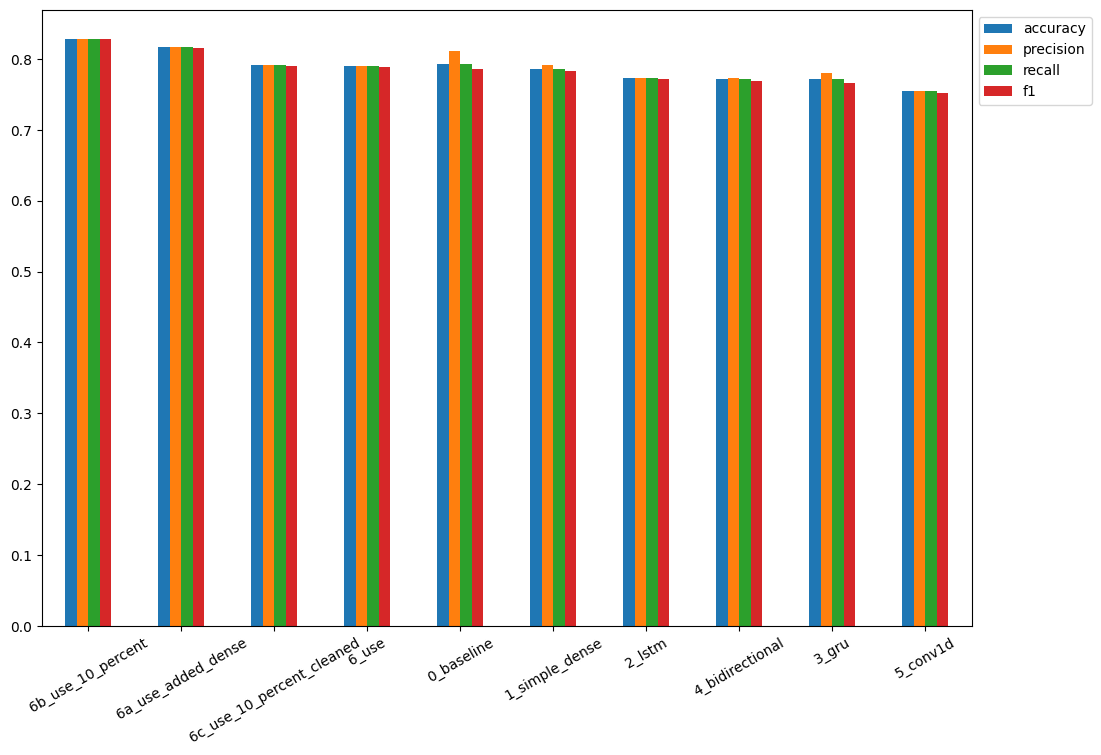

In [107]:
# plot model results
model_metrics_all_transposed_sorted.plot(
    kind='bar',
    rot=30,
    figsize=(12,8)).legend(bbox_to_anchor=(1.0, 1.0)
)

![(Re) Introduction to Tensorflow Natural Language Processing](./assets/tf_nlp_desaster_tweets_02.png)

In [198]:
# Load TensorBoard
%load_ext tensorboard
%tensorboard --logdir './tensorboad/'

![(Re) Introduction to Tensorflow Natural Language Processing](./assets/tf_nlp_desaster_tweets_03.png)

![(Re) Introduction to Tensorflow Natural Language Processing](./assets/tf_nlp_desaster_tweets_04.png)

## Saving & Loading Trained Model

### HDF5 Format (Higher Compatibility to 3rd Parties)

In [199]:
# save best performing model to HDF5 format
model_6a.save('./models/6a_use_added_dense.h5')

In [200]:
# restore model with custom TF Hub layer (only HDF5 format)
# restoring requires import tensorflow_hub as hub
loaded_model_6a = tf.keras.models.load_model(
    './models/6a_use_added_dense.h5',
    custom_objects={'KerasLayer': hub.KerasLayer}
)

2023-04-23 20:15:34.310727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-04-23 20:15:34.368474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


In [201]:
# verify loaded model
loaded_model_6a.evaluate(val_tweets, val_labels) == model_6a.evaluate(val_tweets, val_labels)
# True

24/24 [==============================] - 0s 4ms/step - loss: 0.4252 - accuracy: 0.8136


True

### Saved Model Format (Tensorflow Default)

In [108]:
# save best performing model to saved_model format
model_6a.save('./models/6a_use_added_dense')

2023-04-24 13:01:23.842540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-04-24 13:01:23.900380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_6' with dtype string and shape [?]
	 [[{{node input_6}}]]
2023-04-24 13:01:23.975478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-04-24 13:01:24.035951: I tensorf

INFO:tensorflow:Assets written to: ./models/6a_use_added_dense/assets


INFO:tensorflow:Assets written to: ./models/6a_use_added_dense/assets


In [109]:
loaded_model_6a_saved_model = tf.keras.models.load_model(
    './models/6a_use_added_dense',
)

2023-04-24 13:01:43.789634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-04-24 13:01:43.847042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


In [110]:
# verify loaded model
loaded_model_6a_saved_model.evaluate(val_tweets, val_labels) == model_6a.evaluate(val_tweets, val_labels)
# True

24/24 [==============================] - 0s 5ms/step - loss: 0.4236 - accuracy: 0.8163


True

## Best Model Evaluation

In [112]:
# find most wrong predictions
## create dataframe with validation tweets, labels and model predictions
loaded_model_pred_probs = tf.squeeze(loaded_model_6a_saved_model.predict(val_tweets))
loaded_model_preds = tf.round(loaded_model_pred_probs)
print(loaded_model_preds[:5])
# [0. 1. 1. 0. 1.]

24/24 [==============================] - 0s 4ms/step
tf.Tensor([0. 1. 1. 0. 1.], shape=(5,), dtype=float32)


In [113]:
pred_df = pd.DataFrame({
    "text": val_tweets,
    "target": val_labels,
    "pred": loaded_model_preds,
    "pred_prob": loaded_model_pred_probs
})

pred_df

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.211551
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.788260
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.989896
3,@camilacabello97 Internally and externally scr...,1,0.0,0.231131
4,Radiation emergency #preparedness starts with ...,1,1.0,0.704475
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.142349
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.115426
759,FedEx will no longer transport bioterror patho...,0,1.0,0.895312
760,Crack in the path where I wiped out this morni...,0,1.0,0.718347


|	| text | target | pred | pred_prob |
| -- | -- | -- | -- | -- | 
| 0 | DFR EP016 Monthly Meltdown - On Dnbheaven 2015... | 0 | 0.0 | 0.191866 |
| 1 | FedEx no longer to transport bioterror germs i... | 0 | 1.0 | 0.793415 |
| 2 | Gunmen kill four in El Salvador bus attack: Su... | 1 | 1.0 | 0.992559 |
| 3 | @camilacabello97 Internally and externally scr... | 1 | 0.0 | 0.255227 |
| 4 | Radiation emergency #preparedness starts with ... | 1 | 1.0 | 0.722030 |
...
| 757 | That's the ultimate road to destruction | 0 | 0.0 | 0.141685 |
| 758 | @SetZorah dad why dont you claim me that mean ... | 0 | 0.0 | 0.111817 |
| 759 | FedEx will no longer transport bioterror patho... | 0 | 1.0 | 0.898317 |
| 760 | Crack in the path where I wiped out this morni... | 0 | 1.0 | 0.671607 |
| 761 | I liked a @YouTube video from @dannyonpc http:... | 0 | 0.0 | 0.127992 |

In [114]:
# create another datframe that only contains wrong predictions
most_wrong = pred_df[pred_df['target'] != pred_df['pred']].sort_values(
    'pred_prob',
    ascending=False
)

most_wrong

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.917166
759,FedEx will no longer transport bioterror patho...,0,1.0,0.895312
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.879588
628,@noah_anyname That's where the concentration c...,0,1.0,0.862645
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.843334
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.057629
233,I get to smoke my shit in peace,1,0.0,0.056021
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.048836
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.042986


|	| text | target | pred | pred_prob |
| -- | -- | -- | -- | -- | 
| 31 | ? High Skies - Burning Buildings ? http://t.co... | 0 | 1.0 | 0.936771 |
| 628 | @noah_anyname That's where the concentration c... | 0 | 1.0 | 0.907564 |
| 759 | FedEx will no longer transport bioterror patho... | 0 | 1.0 | 0.898317 |
| 251 | @AshGhebranious civil rights continued in the ... | 0 | 1.0 | 0.854326 |
| 49 | @madonnamking RSPCA site multiple 7 story high... | 0 | 1.0 | 0.853781 |
...
| 233 | I get to smoke my shit in peace | 1 | 0.0 | 0.052748 |
| 411 | @SoonerMagic_ I mean I'm a fan but I don't nee... | 1 | 0.0 | 0.046553 |
| 244 | Reddit Will Now QuarantineÛ_ http://t.co/pkUA... | 1 | 0.0 | 0.044474 |
| 23 | Ron &amp; Fez - Dave's High School Crush https... | 1 | 0.0 | 0.040853 |
| 38 | Why are you deluged with low self-image? Take ... | 1 | 0.0 | 0.040229 |

#### False Positives

In [115]:
for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Probability: {pred_prob}")
    print(f"Tweet: {text}")
    print("----\n")

Target: 0, Pred: 1.0, Probability: 0.9171655774116516
Tweet: ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying
----

Target: 0, Pred: 1.0, Probability: 0.8953118324279785
Tweet: FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J
----

Target: 0, Pred: 1.0, Probability: 0.8795878887176514
Tweet: @madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods
----

Target: 0, Pred: 1.0, Probability: 0.8626453876495361
Tweet: @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.
----

Target: 0, Pred: 1.0, Probability: 0.8433336615562439
Tweet: [55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY
----

Target: 0, Pred: 1.0, Probability: 0.842764139175415
Tweet: Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: Eng

```
Target: 0, Pred: 1.0, Probability: 0.936771035194397
Tweet: ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying
----

Target: 0, Pred: 1.0, Probability: 0.9075638055801392
Tweet: @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.
----

Target: 0, Pred: 1.0, Probability: 0.8983168601989746
Tweet: FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J
----

Target: 0, Pred: 1.0, Probability: 0.8543258309364319
Tweet: @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.
----

Target: 0, Pred: 1.0, Probability: 0.8537805676460266
Tweet: @madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods
----

Target: 0, Pred: 1.0, Probability: 0.8336963057518005
Tweet: [55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY
----

Target: 0, Pred: 1.0, Probability: 0.833143413066864
Tweet: Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
----

Target: 0, Pred: 1.0, Probability: 0.8305423855781555
Tweet: @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!
----

Target: 0, Pred: 1.0, Probability: 0.8277301788330078
Tweet: Deaths 3 http://t.co/nApviyGKYK
----

Target: 0, Pred: 1.0, Probability: 0.8111591935157776
Tweet: The Sound of Arson
----
```

#### False Negatives

In [116]:
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Probability: {pred_prob}")
    print(f"Tweet: {text}")
    print("----\n")

Target: 1, Pred: 0.0, Probability: 0.08482133597135544
Tweet: 'The way you move is like a full on rainstorm and I'm a house of cards'
----

Target: 1, Pred: 0.0, Probability: 0.08254487812519073
Tweet: @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
----

Target: 1, Pred: 0.0, Probability: 0.08116379380226135
Tweet: VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK
----

Target: 1, Pred: 0.0, Probability: 0.07389821112155914
Tweet: @DavidVonderhaar At least you were sincere ??
----

Target: 1, Pred: 0.0, Probability: 0.06220388039946556
Tweet: You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
----

Target: 1, Pred: 0.0, Probability: 0.05762890353798866
Tweet: @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

```
Target: 1, Pred: 0.0, Probability: 0.07530134916305542
Tweet: going to redo my nails and watch behind the scenes of desolation of smaug ayyy
----

Target: 1, Pred: 0.0, Probability: 0.07096730172634125
Tweet: @DavidVonderhaar At least you were sincere ??
----

Target: 1, Pred: 0.0, Probability: 0.06341199576854706
Tweet: Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets
----

Target: 1, Pred: 0.0, Probability: 0.06147787347435951
Tweet: You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
----

Target: 1, Pred: 0.0, Probability: 0.05444430932402611
Tweet: @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
----

Target: 1, Pred: 0.0, Probability: 0.0527476891875267
Tweet: I get to smoke my shit in peace
----

Target: 1, Pred: 0.0, Probability: 0.04655275493860245
Tweet: @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren
----

Target: 1, Pred: 0.0, Probability: 0.04447368532419205
Tweet: Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP
----

Target: 1, Pred: 0.0, Probability: 0.04085317254066467
Tweet: Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube
----

Target: 1, Pred: 0.0, Probability: 0.0402291864156723
Tweet: Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy
----
```

## Test Dataset Predictions

In [117]:
# get the test dataset and randomize
test_df_shuffle = test_df.sample(frac=1, random_state=SEED)

test_df_shuffle.head(5)

,id,keyword,location,text
2406,8051,refugees,NaN,Refugees as citizens - The Hindu http://t.co/G...
134,425,apocalypse,Currently Somewhere On Earth,@5SOStag honestly he could say an apocalypse i...
411,1330,blown%20up,Scout Team,If you bored as shit don't nobody fuck wit you...
203,663,attack,NaN,@RealTwanBrown Yesterday I Had A Heat Attack ?...
889,2930,danger,Leeds,The Devil Wears Prada is still one of my favou...


|	| id 	 | keyword | location | text |
| -- | -- | -- | -- | -- | 
| 2406 | 8051 | refugees | NaN | Refugees as citizens - The Hindu http://t.co/G... |
| 134 | 425 | apocalypse | Currently Somewhere On Earth | @5SOStag honestly he could say an apocalypse i... |
| 411 | 1330 | blown%20up | Scout Team | If you bored as shit don't nobody fuck wit you... |
| 203 | 663 | attack | NaN | @RealTwanBrown Yesterday I Had A Heat Attack ?... |
| 889 | 2930 | danger | Leeds | The Devil Wears Prada is still one of my favou... |

In [118]:
test_tweets = test_df_shuffle['text']
test_tweets = np.array(test_tweets.values.tolist())

In [119]:
loaded_model_pred_probs_test = tf.squeeze(loaded_model_6a_saved_model.predict(test_tweets))
loaded_model_preds_test = tf.round(loaded_model_pred_probs_test)

102/102 [==============================] - 0s 4ms/step


In [120]:
pred_test_df = pd.DataFrame({
    "text": test_tweets,
    "pred": loaded_model_preds_test,
    "pred_prob": loaded_model_pred_probs_test
})

pred_test_df

,text,pred,pred_prob
0,Refugees as citizens - The Hindu http://t.co/G...,1.0,0.691977
1,@5SOStag honestly he could say an apocalypse i...,0.0,0.123520
2,If you bored as shit don't nobody fuck wit you...,0.0,0.094058
3,@RealTwanBrown Yesterday I Had A Heat Attack ?...,0.0,0.124991
4,The Devil Wears Prada is still one of my favou...,0.0,0.032189
...,...,...,...
3258,Free Kindle Book - Aug 3-7 - Thriller - Desola...,0.0,0.082993
3259,HitchBot travels Europe and greeted with open ...,1.0,0.651606
3260,If you told me you was drowning. I would not l...,0.0,0.258282
3261,First time for everything! @ Coney Island Cycl...,1.0,0.685601


|	| text | pred | pred_prob |
| -- | -- | -- | -- | 
| 0 | Refugees as citizens - The Hindu http://t.co/G... | 1.0 | 0.717548 |
| 1 | @5SOStag honestly he could say an apocalypse i... | 0.0 | 0.093809 |
| 2 | If you bored as shit don't nobody fuck wit you... | 0.0 | 0.082749 |
| 3 | @RealTwanBrown Yesterday I Had A Heat Attack ?... | 0.0 | 0.097784 |
| 4 | The Devil Wears Prada is still one of my favou... | 0.0 | 0.028455 |
...
| 3258 | Free Kindle Book - Aug 3-7 - Thriller - Desola... | 0.0 | 0.080420 |
| 3259 | HitchBot travels Europe and greeted with open ... | 1.0 | 0.603396 |
| 3260 | If you told me you was drowning. I would not l... | 0.0 | 0.208108 |
| 3261 | First time for everything! @ Coney Island Cycl... | 1.0 | 0.617582 |
| 3262 | Rocky Fire #cali #SCFD #wildfire #LakeCounty h... | 1.0 | 0.794876 |

In [121]:
# make random prediction on sub-samples of the test dataset
test_samples = random.sample(test_tweets.tolist(), 10)

for test_sample in test_samples:
    pred_prob = tf.squeeze(loaded_model_6a_saved_model.predict([test_sample]))
    pred = tf.round(pred_prob)
    
    print(f"Pred: {int(pred)}, Probability: {pred_prob}")
    print(f"Text: {test_sample}")
    print("-------\n")

1/1 [==============================] - 0s 27ms/step
Pred: 1, Probability: 0.9131472706794739
Text: Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/OFhjcn36o1
-------

1/1 [==============================] - 0s 26ms/step
Pred: 1, Probability: 0.9558534622192383
Text: RT @LivingSafely: NWS posts Severe #Thunderstorm Warnings for parts of #AR #NC #OK. Seek strong shelter if at risk: http://t.co/kImr0l24Fb
-------

1/1 [==============================] - 0s 25ms/step
Pred: 1, Probability: 0.5604234933853149
Text: But is feast.dll still vulnerable to DLL hijacking?  https://t.co/3vaig1PtYk https://t.co/BZDNKpOry1
-------

1/1 [==============================] - 0s 30ms/step
Pred: 0, Probability: 0.06958078593015671
Text: I'm incredibly sad &amp; heartbroken so I'm just going to drown my sorrows in food &amp; watch tv all night ?? http://t.co/yQiZ2p1rSm
-------

1/1 [==============================] - 0s 38ms/step
Pred: 1, Probability: 0.9855814576148987
Text: Su

```
1/1 [==============================] - 0s 26ms/step
Pred: 0, Probability: 0.15592874586582184
Text: @EllaEMusic_ You should have just simply let on that you had electrocuted yourself while plugging in your phone charger. It works for me...
-------

1/1 [==============================] - 0s 25ms/step
Pred: 1, Probability: 0.5131102800369263
Text: Evacuation drill at work. The fire doors wouldn't open so i got to smash the emergency release glass #feelingmanly
-------

1/1 [==============================] - 0s 33ms/step
Pred: 1, Probability: 0.9751215577125549
Text: Rare photographs show the nightmare aftermath of #Hiroshima | #NoNukes #Amerikkka #WhiteTerrorism #Nuclear #Disaster  http://t.co/8tWLAKdaBf
-------

1/1 [==============================] - 0s 28ms/step
Pred: 1, Probability: 0.676400899887085
Text: kayaking about killed us so mom and grandma came to the rescue.
-------

1/1 [==============================] - 0s 26ms/step
Pred: 1, Probability: 0.9690964818000793
Text: Pasco officials impressed by drone video showing floods: Drone videos have given an up-close view of flooded areasÛ_ http://t.co/PrUunEDids
-------

1/1 [==============================] - 0s 29ms/step
Pred: 0, Probability: 0.07793092727661133
Text: just trying to smoke and get Taco Bell
-------

1/1 [==============================] - 0s 26ms/step
Pred: 1, Probability: 0.9799614548683167
Text: RT AbbsWinston: #Zionist #Terrorist kidnapped 15 #Palestinians in overnight terror on Palestinian Villages Û_ http://t.co/J5mKcbKcov
-------

1/1 [==============================] - 0s 24ms/step
Pred: 1, Probability: 0.8005449771881104
Text: ME: gun shot wounds 3 4 6 7 'rapidly lethal' would have killed in 30-60 seconds or few minutes max. #kerricktrial
-------

1/1 [==============================] - 0s 24ms/step
Pred: 1, Probability: 0.9902410507202148
Text: Three Israeli soldiers wounded in West Bank terrorist attack - Haaretz http://t.co/Mwd1iPMoWT #world
-------

1/1 [==============================] - 0s 29ms/step
Pred: 0, Probability: 0.03447313234210014
Text: @_Souuul * gains super powers im now lava girl throws you ina chest wrapped in chains &amp; sinks you down the the bottom of the ocean*
-------
```

## Speed/Score Tradeoff

In [122]:
model_6_time_to_prediction, model_6_prediction_time_weighted = time_to_prediction(
    model = loaded_model_6a_saved_model,
    samples = test_tweets
)

print(model_6_time_to_prediction, model_6_prediction_time_weighted)
# 0.5129240550013492 0.00015719401011380607

102/102 [==============================] - 0s 4ms/step
0.5129240550013492 0.00015719401011380607


In [123]:
model_0_time_to_prediction, model_0_prediction_time_weighted = time_to_prediction(
    model = model_0,
    samples = test_tweets
)

print(model_0_time_to_prediction, model_0_prediction_time_weighted)
# 0.05225817499922414 1.6015376953485792e-05

0.05225817499922414 1.6015376953485792e-05


array([<AxesSubplot: title={'center': 'TimeToPrediction'}>,
       <AxesSubplot: title={'center': 'TimeToPrediction (weighted)'}>],
      dtype=object)

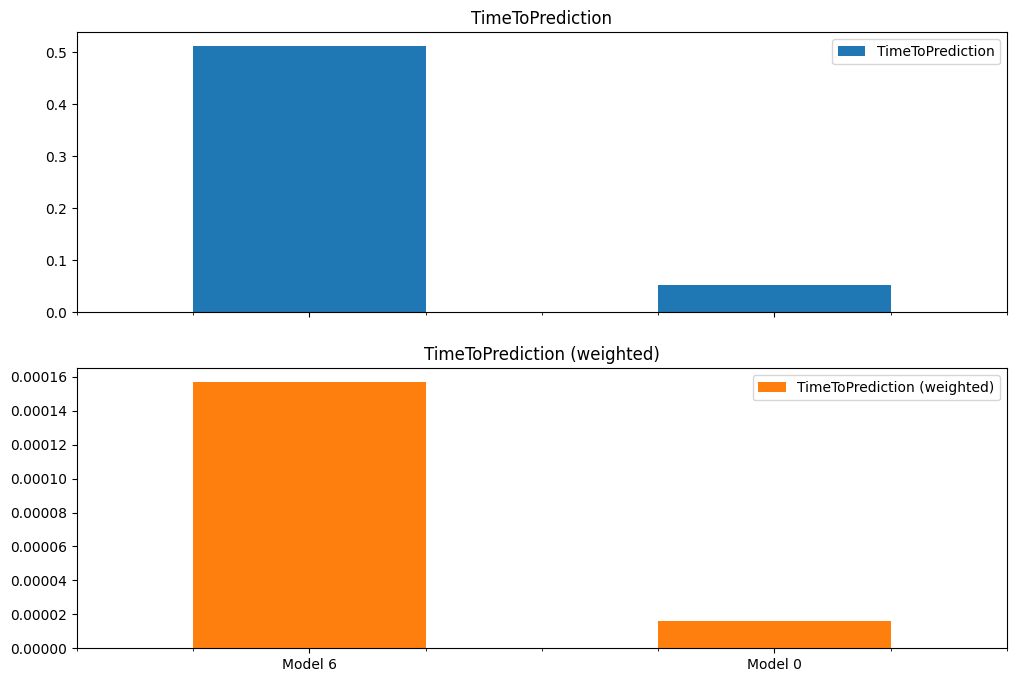

In [124]:
TimeToPrediction = [model_6_time_to_prediction, model_0_time_to_prediction]
TimeToPredictionWeighted = [model_6_prediction_time_weighted, model_0_prediction_time_weighted]
index = ['Model 6', 'Model 0']

prediction_times_df = pd.DataFrame({
    'TimeToPrediction': TimeToPrediction,
    'TimeToPrediction (weighted)': TimeToPredictionWeighted
}, index=index)

prediction_times_df.plot(
    kind='bar',
    rot=0,
    subplots=True,
    figsize=(12,8)
)

![(Re) Introduction to Tensorflow Natural Language Processing](./assets/tf_nlp_desaster_tweets_05.png)

#### Comparing the Performance of all Models

In [125]:
model_1_time_to_prediction, model_1_prediction_time_weighted = time_to_prediction(
    model = model_1,
    samples = test_tweets
)

model_2_time_to_prediction, model_2_prediction_time_weighted = time_to_prediction(
    model = model_2,
    samples = test_tweets
)

model_3_time_to_prediction, model_3_prediction_time_weighted = time_to_prediction(
    model = model_3,
    samples = test_tweets
)

model_4_time_to_prediction, model_4_prediction_time_weighted = time_to_prediction(
    model = model_4,
    samples = test_tweets
)

model_5_time_to_prediction, model_5_prediction_time_weighted = time_to_prediction(
    model = model_5,
    samples = test_tweets
)

model_6_time_to_prediction, model_6_prediction_time_weighted = time_to_prediction(
    model = model_6,
    samples = test_tweets
)

model_6a_time_to_prediction, model_6a_prediction_time_weighted = time_to_prediction(
    model = model_6a,
    samples = test_tweets
)

model_6b_time_to_prediction, model_6b_prediction_time_weighted = time_to_prediction(
    model = model_6b,
    samples = test_tweets
)

model_6c_time_to_prediction, model_6c_prediction_time_weighted = time_to_prediction(
    model = model_6c,
    samples = test_tweets
)

102/102 [==============================] - 0s 4ms/step


Text(0, 0.5, 'F1-Score')

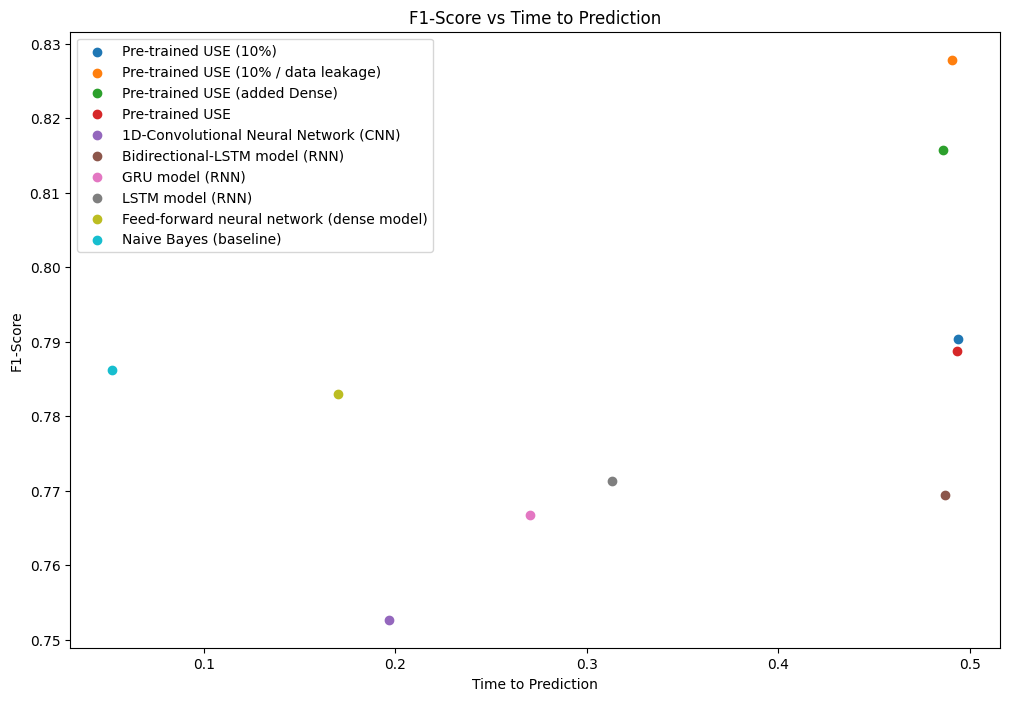

In [126]:
plt.figure(figsize=(12, 8))
plt.scatter(model_6c_time_to_prediction, model_6c_metrics['f1'], label='Pre-trained USE (10%)')
plt.scatter(model_6b_time_to_prediction, model_6b_metrics['f1'], label='Pre-trained USE (10% / data leakage)')
plt.scatter(model_6a_time_to_prediction, model_6a_metrics['f1'], label='Pre-trained USE (added Dense)')
plt.scatter(model_6_time_to_prediction, model_6_metrics['f1'], label='Pre-trained USE')
plt.scatter(model_5_time_to_prediction, model_5_metrics['f1'], label='1D-Convolutional Neural Network (CNN)')
plt.scatter(model_4_time_to_prediction, model_4_metrics['f1'], label='Bidirectional-LSTM model (RNN)')
plt.scatter(model_3_time_to_prediction, model_3_metrics['f1'], label='GRU model (RNN)')
plt.scatter(model_2_time_to_prediction, model_2_metrics['f1'], label='LSTM model (RNN)')
plt.scatter(model_1_time_to_prediction, model_1_metrics['f1'], label='Feed-forward neural network (dense model)')
plt.scatter(model_0_time_to_prediction, baseline_metrics['f1'], label='Naive Bayes (baseline)')
plt.legend()
plt.title("F1-Score vs Time to Prediction")
plt.xlabel('Time to Prediction')
plt.ylabel('F1-Score')

![(Re) Introduction to Tensorflow Natural Language Processing](./assets/tf_nlp_desaster_tweets_06.png)